## TensorFlow 2 CNN


## 导入库

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback

## 数据集划分

In [2]:
data_dir = f"./Glory of Kings/train"
test_dir = f"./Glory of Kings/test"
epochs = 200
batch_size = 32
img_height = 224
img_width = 224
validation_split=0.2
early_stopping_val = 0.04
single_test_path = f'{test_dir}/houyi/houyi1.jpg'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3607 files belonging to 3 classes.
Using 2886 files for training.
Found 3607 files belonging to 3 classes.
Using 721 files for validation.
['houyi', 'kai', 'wangzhaojun']


In [3]:
class_labels = '\n'.join(sorted(class_names))
with open('labels.txt', 'w') as f:
  f.write(class_labels)

## 可视化数据

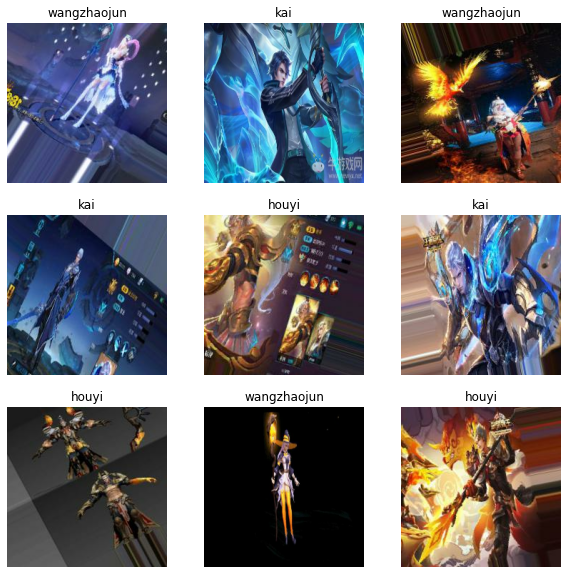

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 配置 dataset 性能

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 标准化数据

In [6]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 数据增强

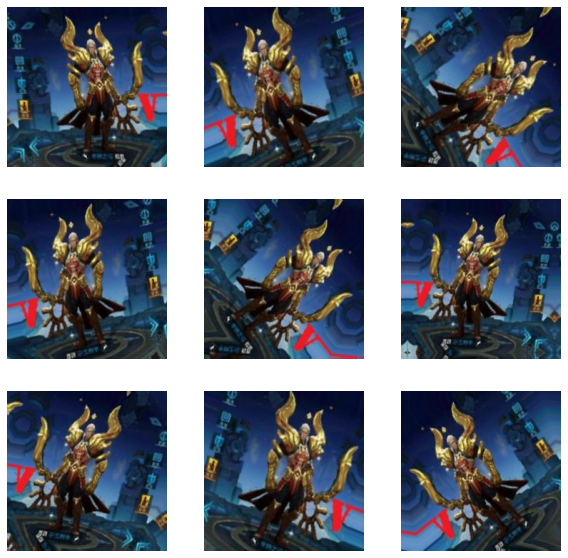

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model

In [8]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),    
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)       

In [9]:
# https://stackoverflow.com/questions/37293642/how-to-tell-keras-stop-training-based-on-loss-value
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
callbacks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=early_stopping_val, verbose=1)
]

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/200
91/91 [==============================] - 5s 39ms/step - loss: 0.9317 - accuracy: 0.5519 - val_loss: 0.6927 - val_accuracy: 0.6865
Epoch 2/200
91/91 [==============================] - 3s 31ms/step - loss: 0.6976 - accuracy: 0.6952 - val_loss: 0.5349 - val_accuracy: 0.7781
Epoch 3/200
91/91 [==============================] - 3s 30ms/step - loss: 0.4985 - accuracy: 0.7887 - val_loss: 0.4935 - val_accuracy: 0.7864
Epoch 4/200
91/91 [==============================] - 3s 30ms/step - loss: 0.4443 - accuracy: 0.8192 - val_loss: 0.4273 - val_accuracy: 0.8350
Epoch 5/200
91/91 [==============================] - 3s 30ms/step - loss: 0.3955 - accuracy: 0.8467 - val_loss: 0.3698 - val_accuracy: 0.8710
Epoch 6/200
91/91 [==============================] - 3s 30ms/step - loss: 0.3209 - accuracy: 0.8827 - val_loss: 0.5367 - val_accuracy: 0.7989
Epoch 7/200
91/91 [==============================] - 3s 30ms/step - loss: 0.2641 - accuracy: 0.8954 - val_loss: 0.3085 - val_accuracy: 0.8904
Epoch 

## 可视化训练结果

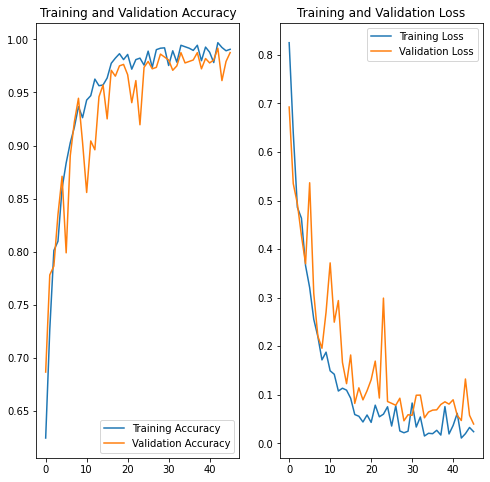

In [11]:
def show_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
show_history(history, epochs)

## 保存模型

In [12]:
import time

cur_time = time.strftime("%Y-%m-%d-%H-%M", time.localtime())
model_name = f"gok_{cur_time}"

# save for mobile
tf_mobile_model_path = "models/mobile/"
tf.saved_model.save(model, tf_mobile_model_path)
# save tflite
converter = tf.lite.TFLiteConverter.from_saved_model(tf_mobile_model_path)
tflite_model = converter.convert()
tflite_model_path = f"models/mobile/{model_name}.tflite"
open(tflite_model_path, "wb").write(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

tflite_quantized_model_path = f"models/mobile/quantized_{model_name}.tflite"
open(tflite_quantized_model_path, "wb").write(tflite_quantized_model)

# save tf model for tf serving
tf_model_path = "models/tf/"
tf.keras.models.save_model(
    model,
    tf_model_path,
    overwrite=True, 
    include_optimizer=True, 
    save_format=None,
    signatures=None, 
    options=None
)

# save h5
model_path = f"models/h5/{model_name}.h5"
model.save(model_path)

INFO:tensorflow:Assets written to: models/mobile/assets
INFO:tensorflow:Assets written to: models/tf/assets


## 预测模型

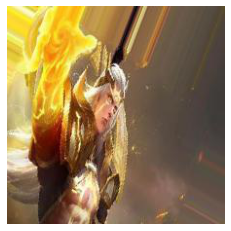

This image most likely belongs to houyi with a 57.61 percent confidence.


In [13]:
from tensorflow.keras.preprocessing import image

def load_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    show_tensor = img_tensor/255.

    plt.imshow(show_tensor[0])                          
    plt.axis('off')
    plt.show()

    return img_tensor

img_tensor = load_image(single_test_path)

predictions = model.predict(img_tensor)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [14]:
# 加载一批图像
def load_image_list(test_dir, count=10):
    image_tensor_list = []
    image_list = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)]
    image_list = image_list[:count]
    for image_path in image_list:
        print(image_path)
        img = image.load_img(image_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)                    
        img_tensor = np.expand_dims(img_tensor, axis=0)
        image_tensor_list.append(img_tensor.reshape(img_width, img_height,3))
    return np.asarray(image_tensor_list)

for c in class_names:
    img_list = load_image_list(f"{test_dir}/{c}/")
    preds = model.predict_on_batch(img_list)
    results = [class_names[np.argmax(prob)] for prob in preds]
    print(results)

./Glory of Kings/test/houyi/houyi216.jpg
./Glory of Kings/test/houyi/houyi143.jpg
./Glory of Kings/test/houyi/houyi174.jpg
./Glory of Kings/test/houyi/houyi112.jpg
./Glory of Kings/test/houyi/houyi148.jpg
./Glory of Kings/test/houyi/houyi184.jpg
./Glory of Kings/test/houyi/houyi107.jpg
./Glory of Kings/test/houyi/houyi133.jpg
./Glory of Kings/test/houyi/houyi57.jpg
./Glory of Kings/test/houyi/houyi12.jpg
['houyi', 'houyi', 'houyi', 'houyi', 'houyi', 'houyi', 'houyi', 'houyi', 'houyi', 'houyi']
./Glory of Kings/test/kai/kai272.jpg
./Glory of Kings/test/kai/kai278.jpg
./Glory of Kings/test/kai/kai260.jpg
./Glory of Kings/test/kai/kai227.jpg
./Glory of Kings/test/kai/kai135.jpg
./Glory of Kings/test/kai/kai232.jpg
./Glory of Kings/test/kai/kai114.jpg
./Glory of Kings/test/kai/kai226.jpg
./Glory of Kings/test/kai/kai192.jpg
./Glory of Kings/test/kai/kai130.jpg
['kai', 'kai', 'kai', 'kai', 'kai', 'kai', 'kai', 'kai', 'kai', 'kai']
./Glory of Kings/test/wangzhaojun/wangzhaojun303.jpg
./Glory